In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import ta
import pickle
from gym_anytrading.envs import StocksEnv,Actions,Positions
from stable_baselines3 import PPO, A2C
from sb3_contrib import RecurrentPPO
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

warnings.filterwarnings("ignore")

In [2]:
window_size = 20
start_date = '2024-01-01'
today = datetime.today().date()
end_date = today.strftime("%Y-%m-%d")

with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('columns_to_scale.pkl', 'rb') as f:
    columns_to_scale = pickle.load(f)

# 1. Custom Environment

In [3]:
class CustomStocksEnv(StocksEnv):
    def __init__(self, df, window_size, frame_bound, render_mode=None):
        super().__init__(df, window_size, frame_bound, render_mode)

        self.trade_fee_bid_percent = 0.001  # unit
        self.trade_fee_ask_percent = 0.001

    def _process_data(self):
        start = self.frame_bound[0] - self.window_size
        end = self.frame_bound[1]
        prices = self.df.loc[:, 'Close'].to_numpy()[start:end]
        signal_features = self.df.drop(['Close'],axis=1).to_numpy()[start:end]

        diff = np.insert(np.diff(prices), 0, 0)
        signal_features = np.column_stack((prices, diff, signal_features))

        close_col_idx = self.df.columns.get_loc('Close')
        close_mean = scaler.mean_[close_col_idx]
        close_scale = scaler.scale_[close_col_idx]
        # invert scaling
        prices = prices * close_scale + close_mean

        return prices.astype(np.float32), signal_features.astype(np.float32)

    def _update_profit(self, action):
        trade = False
        if (
            (action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)
        ):
            trade = True

        if trade or self._truncated:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]

            if self._position == Positions.Long:
                shares = (self._total_profit * (1 - self.trade_fee_ask_percent)) / last_trade_price
                self._total_profit = (shares * (1 - self.trade_fee_bid_percent)) * current_price


In [4]:
def load_data(ticker):
    stock_data = yf.Ticker(ticker).history(start=start_date, end=end_date, interval='1d')

    df = stock_data.reset_index()#[['Date','Close']]

    df.sort_values(by=['Date'], inplace=True)

    data = df.copy()

    # Calculate Simple Moving Average (SMA)
    data['sma'] = ta.trend.sma_indicator(data['Close'], window=10)

    # Calculate Exponential Moving Average (EMA)
    data['ema'] = ta.trend.ema_indicator(data['Close'], window=10)

    # Calculate Moving Average Convergence Divergence (MACD)
    macd = ta.trend.MACD(data['Close'])
    data['macd'] = macd.macd()
    data['macd_signal'] = macd.macd_signal()
    data['macd_diff'] = macd.macd_diff()

    # Calculate Stochastic Oscillator
    stochastic_osc = ta.momentum.StochasticOscillator(data['High'], data['Low'], data['Close'], window=10, smooth_window=3)
    data['stoch'] = stochastic_osc.stoch()
    data['stoch'].replace([-float('inf'), float('inf')], np.nan, inplace=True)
    data['stoch_signal'] = stochastic_osc.stoch_signal()

    # Calculate Relative Strength Index (RSI)
    data['rsi'] = ta.momentum.rsi(data['Close'], window=10)

    # Calculate Average True Range (ATR)
    data['atr'] = ta.volatility.average_true_range(data['High'], data['Low'], data['Close'], window=10)

    # Calculate Accumulation Distribution Index (ADI)
    data['adi'] = ta.volume.acc_dist_index(data['High'], data['Low'], data['Close'], data['Volume'])
    data['adi'].replace([np.inf, -np.inf], 0, inplace=True)

    # Calculate Bollinger Bands
    bollinger = ta.volatility.BollingerBands(data['Close'], window=20, window_dev=2)
    data['bollinger_hband'] = bollinger.bollinger_hband()
    data['bollinger_lband'] = bollinger.bollinger_lband()
    data['bollinger_mavg'] = bollinger.bollinger_mavg()

    #Commodity Channel Index (CCI)
    data['cci'] = ta.trend.cci(data['High'], data['Low'], data['Close'], window=20)

    # Aroon Indicator
    aroon = ta.trend.AroonIndicator(high=data['High'], low=data['Low'], window=25)
    data['aroon_up'] = aroon.aroon_up()
    data['aroon_down'] = aroon.aroon_down()

    # Williams %R
    data['williams_r'] = ta.momentum.williams_r(data['High'], data['Low'], data['Close'], lbp=10)
    data['williams_r'].replace([-float('inf'), float('inf')], np.nan, inplace=True)


    # Money Flow Index (MFI)
    data['mfi'] = ta.volume.money_flow_index(data['High'], data['Low'], data['Close'], data['Volume'], window=10)

    # Rate of Change (ROC)
    data['roc'] = ta.momentum.roc(data['Close'], window=10)

    # Chaikin A/D Line
    data['chaikin_ad'] = ta.volume.ChaikinMoneyFlowIndicator(data['High'], data['Low'], data['Close'], data['Volume'], window=20).chaikin_money_flow()

    # On-Balance Volume (OBV)
    data['obv'] = ta.volume.on_balance_volume(data['Close'], data['Volume'])

    #Remove null values and unecessary columns
    data = data.dropna()
    data.drop(['Dividends','Stock Splits'],axis=1, inplace=True)

    #Scaling
    data[columns_to_scale] = scaler.transform(data[columns_to_scale])
    data.set_index('Date', inplace=True)

    return data

def make_pred_n_visualize(df,model_type,window_size=window_size):
    test_env = CustomStocksEnv(df=df, window_size=window_size, frame_bound=(window_size, len(df)))

    if model_type == 'PPO':
        model_path = './logs/best_model/best_model.zip'
        final_model = PPO.load(model_path)
    elif model_type == 'RecurrentPPO':
        model_path = './logs/best_model_lstm/best_model.zip'
        final_model = RecurrentPPO.load(model_path)
    elif model_type == 'A2C':
        model_path = './logs/best_model_a2c/best_model.zip'
        final_model = A2C.load(model_path)
    else:
        print("Invalid model. Only accept: 'PPO', 'RecurrentPPO', 'A2C'")
        return None

    obs, info = test_env.reset()
    rewards = []
    while True:
        action, _states = final_model.predict(obs, deterministic=True)

        obs, reward, terminated, truncated, info = test_env.step(action)
        done = terminated or truncated
        if done:
            print("Final info:", info)
            break

    plt.figure(figsize=(15, 6))
    plt.cla()
    test_env.unwrapped.render_all()
    #plt.savefig(f"predictions_{model_type}.pdf")  ## Save fig
    plt.show()
    test_env.close()

# 2. Make Predictions

In [5]:
#df = load_data('AMD') #All models result in loss
#df = load_data('INTC') #Some still profit even the stock price is decreasing
#df = load_data('AVGO') #All models profit but not better than holding all the time
df = load_data('ARM') #RecurrentPPO beats the market with 228% profit


In [6]:
df

,Open,High,Low,Close,Volume,sma,ema,macd,macd_signal,macd_diff,...,bollinger_lband,bollinger_mavg,cci,aroon_up,aroon_down,williams_r,mfi,roc,chaikin_ad,obv
Date,,,,,,,,,,,,,,,,,,,,,
2024-02-20 00:00:00-05:00,10.441494,10.241282,9.841719,10.263825,-2.332445,9.811585,9.845393,18.084528,14.002151,17.140036,...,2.663437,7.763585,0.383062,0.575743,-0.842672,-0.103406,1.226002,6.053061,0.462346,-2.270288
2024-02-21 00:00:00-05:00,9.836694,10.409393,9.976983,10.426979,-2.325701,10.326042,9.985375,17.758414,14.957615,12.792790,...,2.844690,8.007665,0.346393,0.464270,-0.956479,-0.052603,1.274394,6.327120,0.599140,-2.267973
2024-02-22 00:00:00-05:00,11.354722,11.694945,11.175919,10.944639,-2.289023,10.851827,10.195561,17.787382,15.728116,10.319479,...,3.054590,8.281581,0.495479,0.352796,-1.070286,-0.263915,1.318209,6.120321,0.195191,-2.264928
2024-02-23 00:00:00-05:00,10.975467,11.447723,11.211785,11.429064,-2.336595,11.050323,10.457045,18.062704,16.402761,9.037732,...,3.324403,8.589950,0.443224,0.241322,0.067784,-0.226071,1.108691,1.379522,0.340902,-2.262831
2024-02-26 00:00:00-05:00,11.970574,12.824252,12.166323,12.724222,-2.304289,11.366590,10.910310,19.296690,17.203534,10.724274,...,3.614839,8.979264,0.640318,0.129848,-0.046023,0.196892,1.066805,2.314010,0.504850,-2.260090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-05 00:00:00-05:00,14.375710,15.200546,14.658983,15.449493,-2.373244,14.075119,14.232588,6.775122,5.714323,4.854745,...,13.007891,13.869483,1.010986,0.018375,-0.842672,1.334642,-0.389623,-0.598237,1.702327,-2.254173
2025-02-06 00:00:00-05:00,14.281272,14.854436,14.269585,14.866370,-2.380308,14.084406,14.395224,7.193115,6.092212,5.069542,...,13.087216,13.989292,0.572932,-0.093099,-0.956479,0.731213,-0.213962,-0.193515,1.907891,-2.255400
2025-02-07 00:00:00-05:00,14.733366,14.882717,14.491951,14.366837,-2.411265,14.084304,14.435985,6.960906,6.345397,3.402043,...,13.201324,14.079109,0.426598,-0.204573,-1.070286,0.214284,-0.189499,-0.246088,1.668796,-2.256011


Final info: {'total_reward': np.float32(21.794983), 'total_profit': np.float32(1.1559223), 'position': <Positions.Short: 0>}


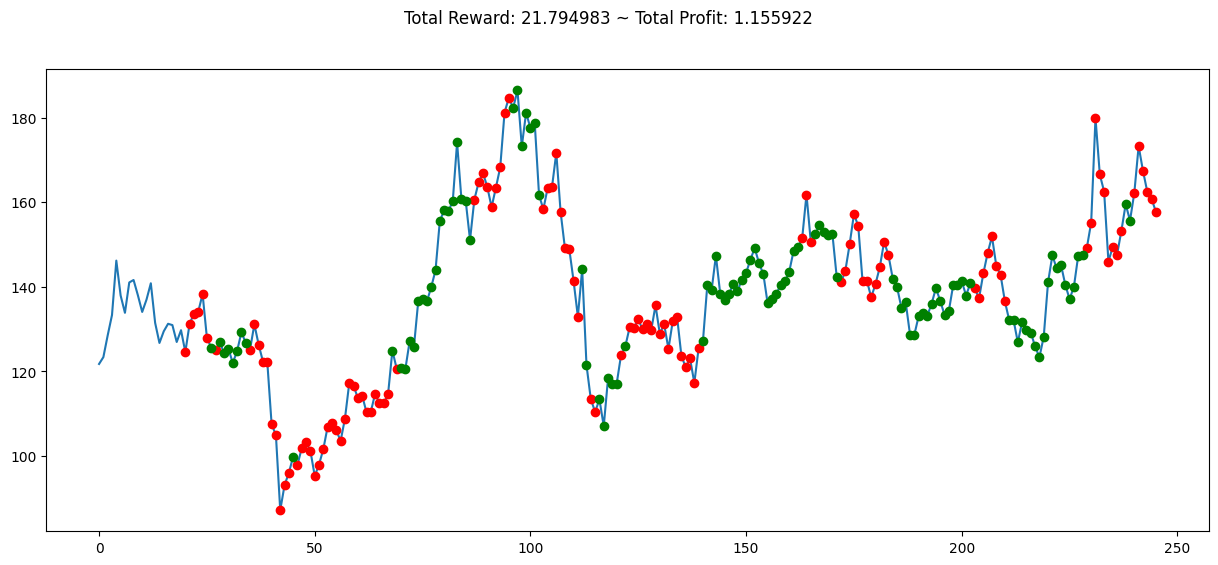

In [7]:
# PPO
make_pred_n_visualize(df,'PPO')

Final info: {'total_reward': np.float32(117.649956), 'total_profit': np.float32(2.2848077), 'position': <Positions.Long: 1>}


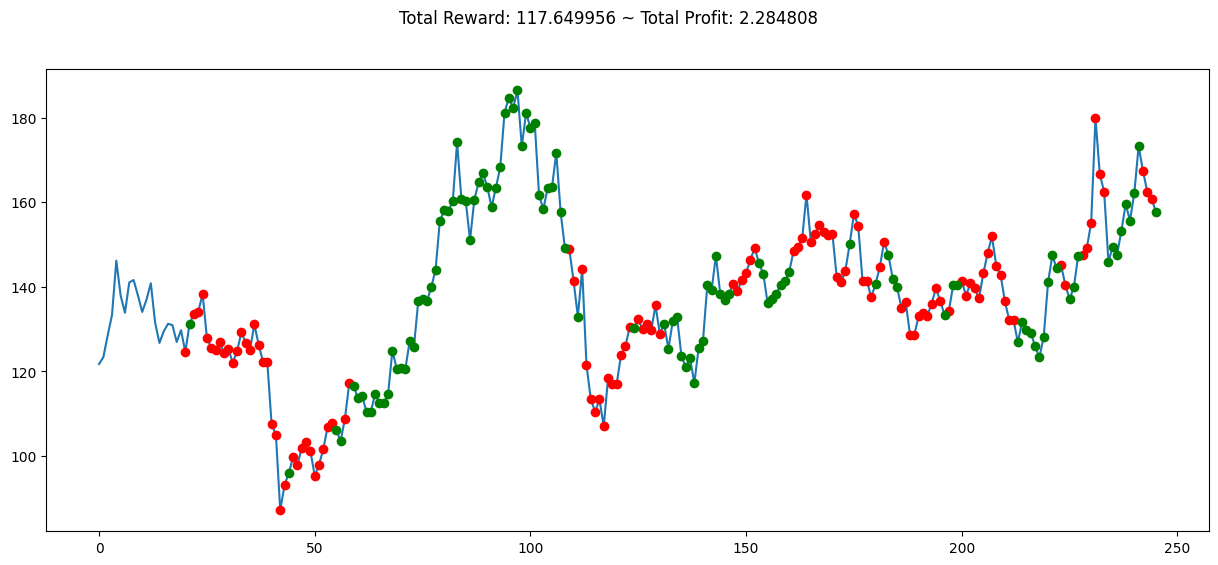

In [8]:
#RecurrentPPO
make_pred_n_visualize(df,'RecurrentPPO')

Final info: {'total_reward': np.float32(7.904991), 'total_profit': np.float32(1.0288306), 'position': <Positions.Short: 0>}


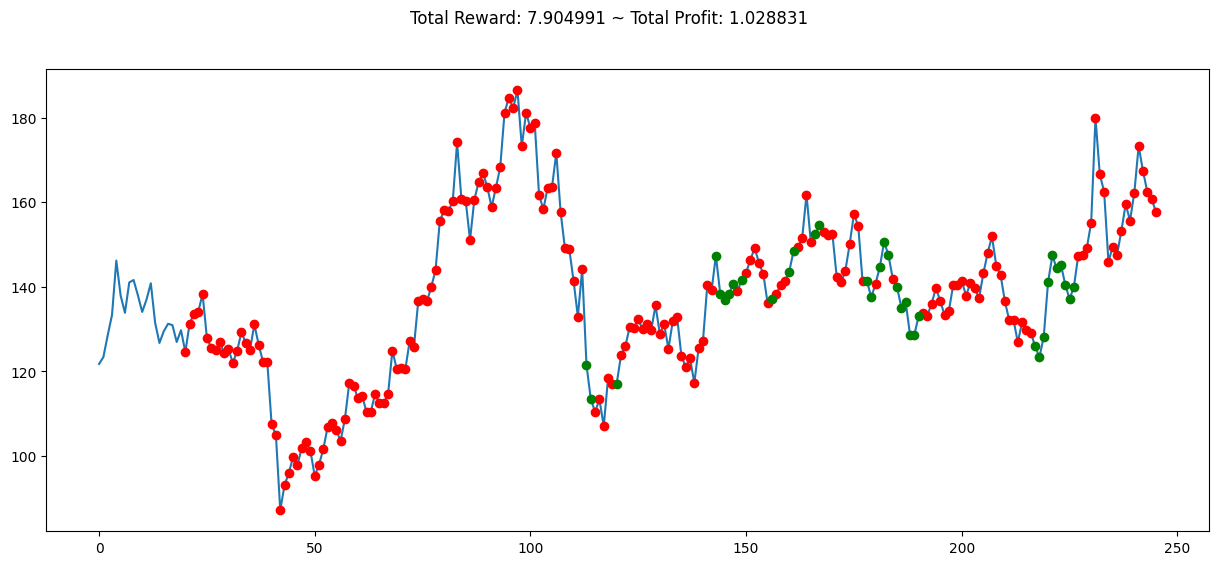

In [9]:
#A2C
make_pred_n_visualize(df,'A2C')

# 3. Compare Performance(Uptrend, Downtrend, Sideways Trend)

In [10]:
def make_pred(df, model_type, window_size=window_size):
    test_env = CustomStocksEnv(df=df, window_size=window_size, frame_bound=(window_size, len(df)))

    if model_type == 'PPO':
        model_path = './logs/best_model/best_model.zip'
        final_model = PPO.load(model_path)
    elif model_type == 'RecurrentPPO':
        model_path = './logs/best_model_lstm/best_model.zip'
        final_model = RecurrentPPO.load(model_path)
    elif model_type == 'A2C':
        model_path = './logs/best_model_a2c/best_model.zip'
        final_model = A2C.load(model_path)
    else:
        print("Invalid model. Only accept: 'PPO', 'RecurrentPPO', 'A2C'")
        return None


    obs, info = test_env.reset()
    final_info = None  # Variable to store final info
    profits = []

    while True:
        action, _states = final_model.predict(obs, deterministic=True)

        obs, reward, terminated, truncated, info = test_env.step(action)
        profits.append(info.get('total_profit',0))

        if terminated or truncated:
            final_info = info  # Store the final info
            break

    test_env.close()

    return final_info, profits  # Return extracted info

def compute_buy_hold(df):
    initial_price = df.iloc[0]['Close']
    final_price = df.iloc[-1]['Close']

    total_profit = final_price / initial_price
    total_reward = total_profit - 1

    return total_reward, total_profit

def moving_average_crossover(df, short_window=10, long_window=50):
    """Compute Moving Average Crossover strategy."""
    df = df.copy()
    df['Short_MA'] = df['Close'].rolling(window=short_window).mean()
    df['Long_MA'] = df['Close'].rolling(window=long_window).mean()

    df['Position'] = 0
    df.loc[df['Short_MA'] > df['Long_MA'], 'Position'] = 1  # Buy
    df.loc[df['Short_MA'] < df['Long_MA'], 'Position'] = -1  # Sell

    df['Daily_Return'] = df['Close'].pct_change() * df['Position'].shift(1)
    
    df['Equity_Curve'] = (df['Daily_Return'] + 1).cumprod()
    total_profit = df['Equity_Curve'].iloc[-1]
    #total_profit = (df['Daily_Return'] + 1).cumprod().iloc[-1]
    
    total_reward = total_profit - 1

    daily_returns = df['Daily_Return'].dropna()
    equity_curve = df['Equity_Curve'].dropna()

    return total_reward, total_profit,daily_returns, equity_curve


def run_tests():
    stocks = ['AMD', 'AVGO', 'TEM']
    models = ['PPO', 'RecurrentPPO', 'A2C']
    results = []

    for stock in stocks:
        df = load_data(stock)

        # Buy & Hold Strategy
        buy_hold_reward, buy_hold_profit = compute_buy_hold(df)
        results.append({'Stock': stock, 'Model': 'Buy&Hold', 'Total Rewards': buy_hold_reward, 'Total Profit': buy_hold_profit})

        # Moving Average Crossover Strategy
        mac_reward, mac_profit,_,_ = moving_average_crossover(df)
        results.append({'Stock': stock, 'Model': 'MovingAvgCrossover', 'Total Rewards': mac_reward, 'Total Profit': mac_profit})

        # Reinforcement Learning Models
        for model in models:
            info,_ = make_pred(df, model)
            if info:
                results.append({'Stock': stock, 'Model': model, 'Total Rewards': info.get('total_reward', 0), 'Total Profit': info.get('total_profit', 0)})

    results_df = pd.DataFrame(results)
    print(results_df)
    return results_df

# Run the tests
results_df = run_tests()


   Stock               Model  Total Rewards  Total Profit
0    AMD            Buy&Hold      -0.374334      0.625666
1    AMD  MovingAvgCrossover      -0.266954      0.733046
2    AMD                 PPO       1.459991      0.993435
3    AMD        RecurrentPPO     -33.289986      0.723326
4    AMD                 A2C      -5.369995      0.960669
5   AVGO            Buy&Hold       1.126995      2.126995
6   AVGO  MovingAvgCrossover      -0.634318      0.365682
7   AVGO                 PPO      38.148193      1.231475
8   AVGO        RecurrentPPO      52.489838      1.315997
9   AVGO                 A2C      11.278931      1.062905
10   TEM            Buy&Hold       1.676353      2.676353
11   TEM  MovingAvgCrossover      -0.970450      0.029550
12   TEM                 PPO      -3.014999      0.920436
13   TEM        RecurrentPPO      27.014992      1.784163
14   TEM                 A2C      24.540001      1.797223


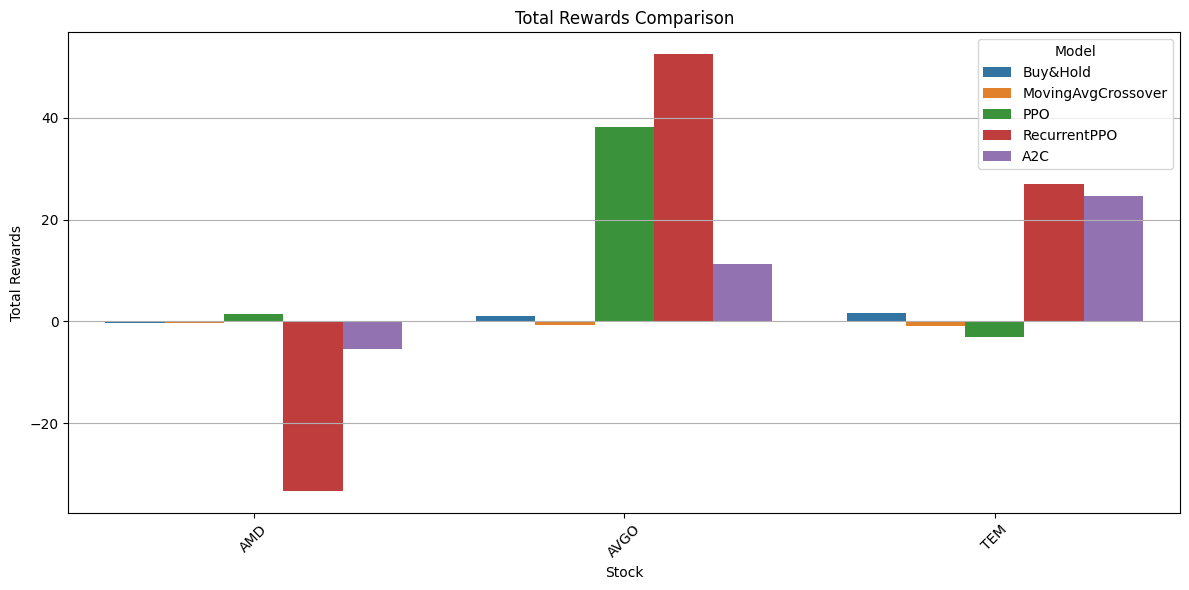

In [11]:
# Set up the figure
plt.figure(figsize=(12, 6), dpi=100)

# Plot total rewards comparison
sns.barplot(data=results_df, x="Stock", y="Total Rewards", hue="Model")
plt.title("Total Rewards Comparison")
plt.xlabel("Stock")
plt.ylabel("Total Rewards")
plt.legend(title="Model")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.savefig("total_rewards_comparison.png")
plt.show()

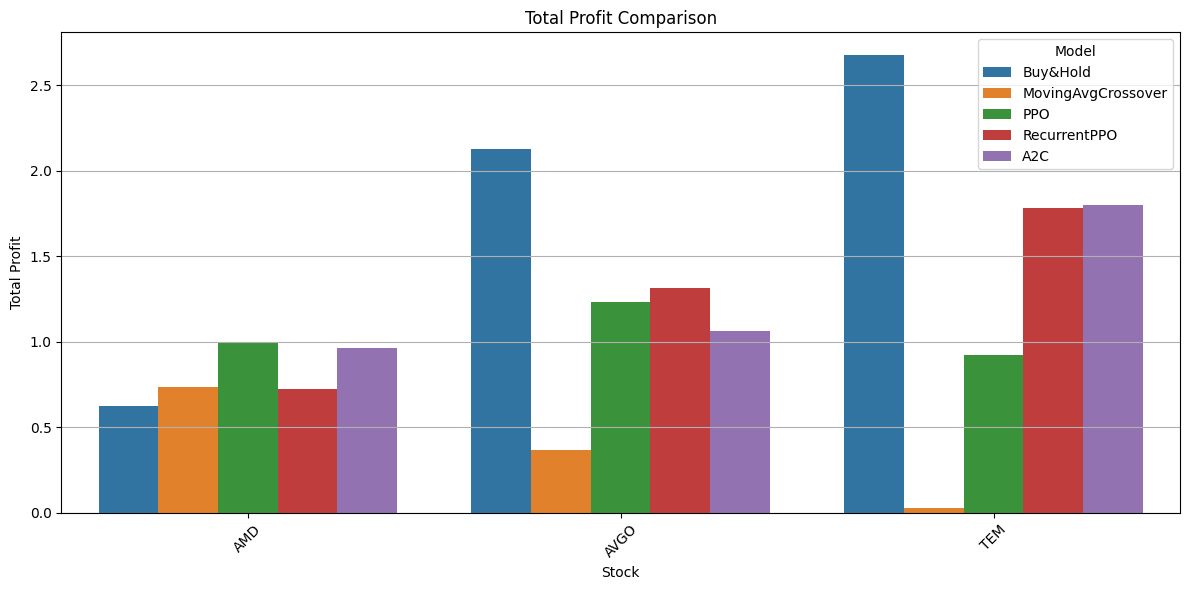

In [12]:
# Set up another figure for total profit
plt.figure(figsize=(12, 6), dpi=100)

# Plot total profit comparison
sns.barplot(data=results_df, x="Stock", y="Total Profit", hue="Model")
plt.title("Total Profit Comparison")
plt.xlabel("Stock")
plt.ylabel("Total Profit")
plt.legend(title="Model")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.savefig("total_profit_comparison.png")
plt.show()

   Stock               Model  Total Rewards  Total Profit  Sharpe Ratio  \
0    AMD            Buy&Hold      -0.374334      0.625666     -0.980446   
1    AMD  MovingAvgCrossover      -0.266954      0.733046     -0.482550   
2    AMD                 PPO       1.459991      0.993435      0.031859   
3    AMD        RecurrentPPO     -33.289986      0.723326     -1.207858   
4    AMD                 A2C      -5.369995      0.960669     -0.187233   
5    ARM            Buy&Hold       0.352950      1.352950      0.681878   
6    ARM  MovingAvgCrossover      -0.463437      0.536563     -0.575526   
7    ARM                 PPO      21.794983      1.155922      0.519636   
8    ARM        RecurrentPPO     117.649956      2.284808      2.449970   
9    ARM                 A2C       7.904991      1.028831      0.162254   
10   TEM            Buy&Hold       1.676353      2.676353      1.456116   
11   TEM  MovingAvgCrossover      -0.970450      0.029550     -1.759779   
12   TEM                 

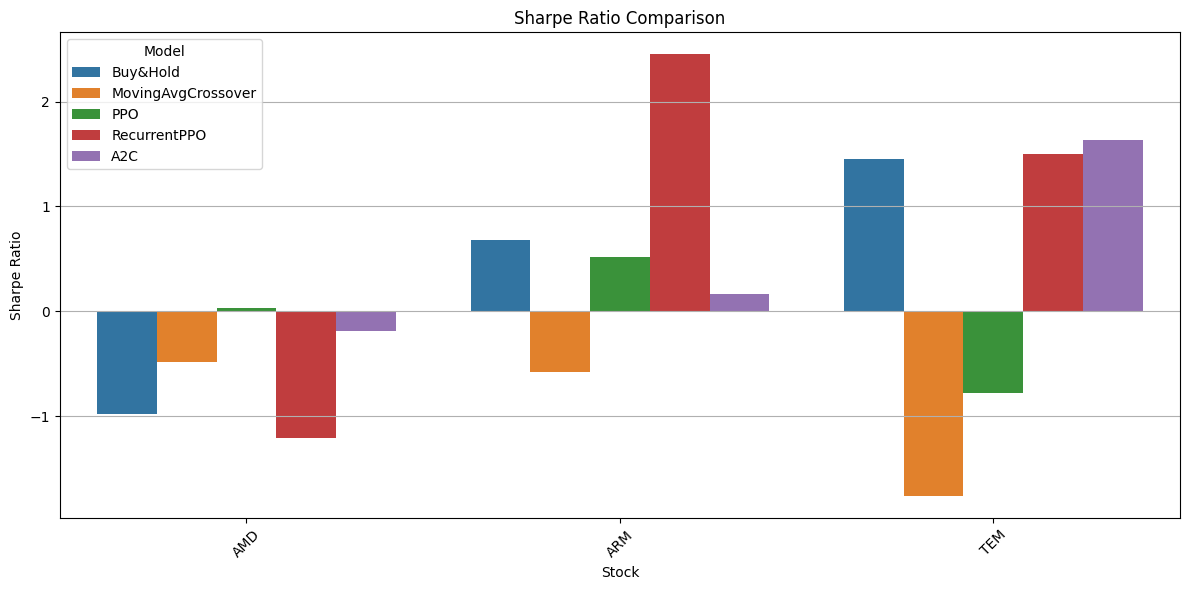

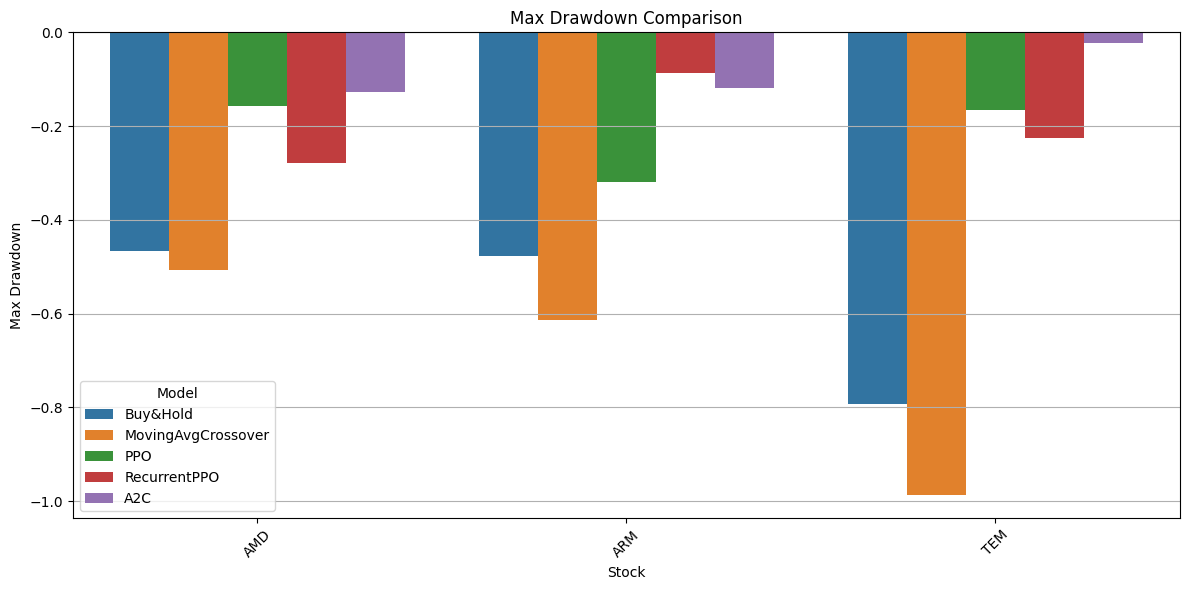

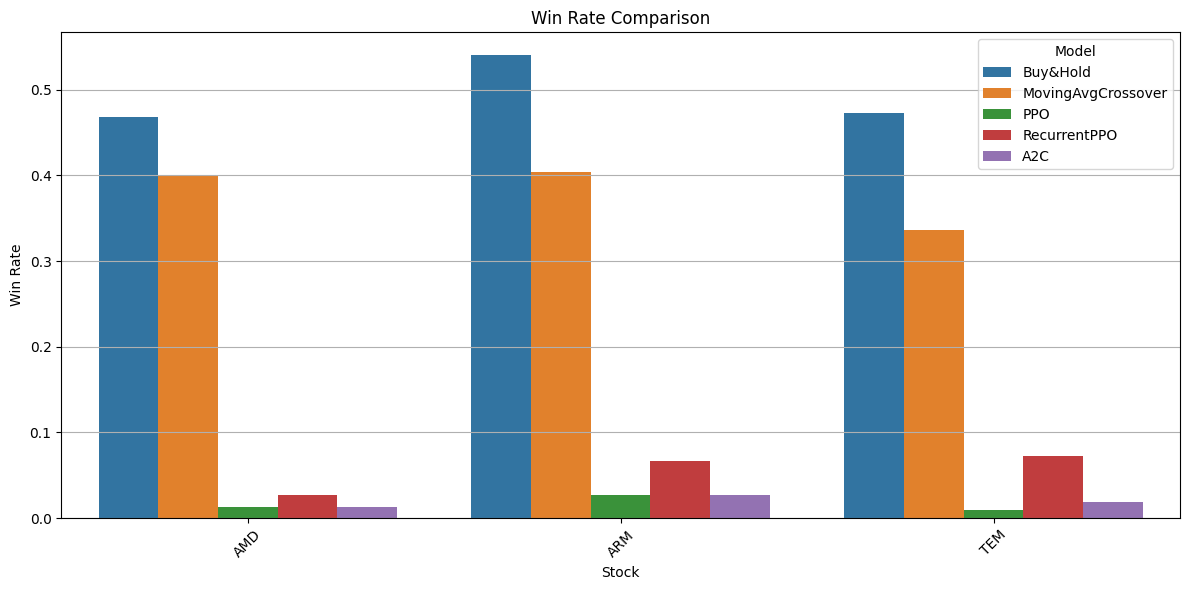

In [13]:

#def compute_sharpe_ratio(df, risk_free_rate=0.02):
#    daily_returns = df['Close'].pct_change().dropna()
#    excess_returns = daily_returns - (risk_free_rate / 252)  # Assuming 252 trading days
#    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)
#    return sharpe_ratio

#def compute_max_drawdown(df):
#    cumulative_returns = (1 + df['Close'].pct_change().dropna()).cumprod()
#    peak = cumulative_returns.cummax()
#    drawdown = (cumulative_returns - peak) / peak
#    max_drawdown = drawdown.min()
#    return max_drawdown

#def compute_win_rate(df, model_positions):
#    daily_returns = df['Close'].pct_change().dropna()
#    wins = (daily_returns > 0).sum()
#    total_trades = (model_positions.diff().fillna(0) != 0).sum()
#    win_rate = wins / total_trades if total_trades > 0 else 0
#    return win_rate

def compute_periodic_returns(equity_curve):
    equity_curve = np.array(equity_curve)
    returns = np.diff(equity_curve) / equity_curve[:-1]
    return returns
     

def calculate_sharpe_ratio(returns, annual_risk_free_rate=0.02, periods_per_year=252):
    returns = np.array(returns)
    risk_free_rate = annual_risk_free_rate/periods_per_year
    excess_returns = returns - risk_free_rate
    
    mean_excess = np.mean(excess_returns)
    std_excess = np.std(excess_returns)
    
    if std_excess == 0:
        return np.nan  # Avoid division by zero
    
    sharpe = (mean_excess / std_excess) * np.sqrt(periods_per_year)
    return sharpe

def calculate_max_drawdown(equity_curve):
    equity_curve = np.array(equity_curve)
    running_max = np.maximum.accumulate(equity_curve)
    drawdowns = (equity_curve - running_max) / running_max
    max_dd = drawdowns.min()
    return max_dd


def calculate_win_rate(returns):
    returns = np.array(returns)
    wins = returns > 0
    win_rate = np.sum(wins) / len(returns)
    return win_rate


def run_tests():
    stocks = ['AMD', 'ARM', 'TEM']
    models = ['PPO', 'RecurrentPPO', 'A2C']
    results = []

    for stock in stocks:
        df = load_data(stock)

        # Buy & Hold Strategy
        buy_hold_reward, buy_hold_profit = compute_buy_hold(df)
        prices = np.array(df['Close'])[window_size+1:]
        daily_returns = np.diff(prices) / prices[:-1]
        equity_curve_buy_hold = np.concatenate(([1.0], np.cumprod(1 + daily_returns)))
        results.append({'Stock': stock, 'Model': 'Buy&Hold', 'Total Rewards': buy_hold_reward, 'Total Profit': buy_hold_profit,
                        'Sharpe Ratio': calculate_sharpe_ratio(daily_returns), 'Max Drawdown': calculate_max_drawdown(equity_curve_buy_hold), 'Win Rate': calculate_win_rate(daily_returns)})

        # Moving Average Crossover Strategy
        mac_reward, mac_profit,mac_daily_returns, mac_equity_curve = moving_average_crossover(df)
        #mac_win_rate = calculate_win_rate(df)
        results.append({'Stock': stock, 'Model': 'MovingAvgCrossover', 'Total Rewards': mac_reward, 'Total Profit': mac_profit,
                        'Sharpe Ratio': calculate_sharpe_ratio(mac_daily_returns), 'Max Drawdown': calculate_max_drawdown(mac_equity_curve), 'Win Rate': calculate_win_rate(mac_daily_returns)})

        # Reinforcement Learning Models
        for model in models:
            info, cumulative_profits = make_pred(df, model)
            returns = compute_periodic_returns(cumulative_profits)
            if info:
                results.append({'Stock': stock, 'Model': model, 'Total Rewards': info.get('total_reward', 0), 'Total Profit': info.get('total_profit', 0),
                                'Sharpe Ratio': calculate_sharpe_ratio(returns), 'Max Drawdown': calculate_max_drawdown(cumulative_profits), 'Win Rate': calculate_win_rate(returns)})

    results_df = pd.DataFrame(results)
    print(results_df)
    return results_df

# Run the tests
results_df = run_tests()

# Set up the figure for Sharpe Ratio Comparison
plt.figure(figsize=(12, 6), dpi=100)
sns.barplot(data=results_df, x="Stock", y="Sharpe Ratio", hue="Model")
plt.title("Sharpe Ratio Comparison")
plt.xlabel("Stock")
plt.ylabel("Sharpe Ratio")
plt.legend(title="Model")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.savefig('sharpe_ratio.png')
plt.show()

# Set up the figure for Max Drawdown Comparison
plt.figure(figsize=(12, 6), dpi=100)
sns.barplot(data=results_df, x="Stock", y="Max Drawdown", hue="Model")
plt.title("Max Drawdown Comparison")
plt.xlabel("Stock")
plt.ylabel("Max Drawdown")
plt.legend(title="Model")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.savefig('max_drawdown.png')
plt.show()

# Set up the figure for Win Rate Comparison
plt.figure(figsize=(12, 6), dpi=100)
sns.barplot(data=results_df, x="Stock", y="Win Rate", hue="Model")
plt.title("Win Rate Comparison")
plt.xlabel("Stock")
plt.ylabel("Win Rate")
plt.legend(title="Model")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.savefig('win_rate.png')
plt.show()

In [14]:
results_df = run_tests()

# Create a summary table
summary_table = results_df[['Stock', 'Model', 'Total Rewards', 'Sharpe Ratio', 'Max Drawdown', 'Win Rate', 'Total Profit']]

# Display the table
print(summary_table)

# Save the table to a CSV file (optional)
summary_table.to_csv('strategy_performance_summary.csv', index=False)

   Stock               Model  Total Rewards  Total Profit  Sharpe Ratio  \
0    AMD            Buy&Hold      -0.374334      0.625666     -0.980446   
1    AMD  MovingAvgCrossover      -0.266954      0.733046     -0.482550   
2    AMD                 PPO       1.459991      0.993435      0.031859   
3    AMD        RecurrentPPO     -33.289986      0.723326     -1.207858   
4    AMD                 A2C      -5.369995      0.960669     -0.187233   
5    ARM            Buy&Hold       0.352950      1.352950      0.681878   
6    ARM  MovingAvgCrossover      -0.463437      0.536563     -0.575526   
7    ARM                 PPO      21.794983      1.155922      0.519636   
8    ARM        RecurrentPPO     117.649956      2.284808      2.449970   
9    ARM                 A2C       7.904991      1.028831      0.162254   
10   TEM            Buy&Hold       1.676353      2.676353      1.456116   
11   TEM  MovingAvgCrossover      -0.970450      0.029550     -1.759779   
12   TEM                 